# Multiple Parallel Agents Asynchronous with State

In this notebook, we will create an asynchronous workflow using a state graph. This workflow involves agents that perform tasks asynchronously, updating and managing their state. We will visualize the state graph and observe the state changes during the workflow execution.

## What You'll Learn

- How to set up and use the `langgraph` library for creating state graphs.
- How to define and manage state objects for asynchronous agents.
- How to create and execute asynchronous workflows.
- How to visualize the state graph and monitor state changes.

## Basic Concepts

Before diving into the implementation, it's essential to understand some basic concepts:

- **Asynchronous Programming:** A form of parallel programming that allows a unit of work to run separately from the main application thread. When the work is complete, it notifies the main thread about its completion, failure, or progress. This is particularly useful for I/O-bound tasks.

- **Agent:** A software component that performs specific tasks asynchronously, such as processing information or generating responses. In this notebook, we implement agents that handle various aspects of a workflow.

- **State:** A shared data structure that stores the context and data required by agents. The state is critical for maintaining continuity and passing information between different parts of the workflow.

- **State Graph:** A directed graph where nodes represent states or actions, and edges represent transitions between states. LangGraph is used to construct and manage these state graphs.

- **Workflow:** A sequence of tasks or operations performed by agents, defined and managed using a state graph. The workflow ensures that tasks are executed in a specific order and that the state is appropriately updated.

Understanding these concepts will provide a solid foundation as we proceed with the practical implementation of asynchronous agents and workflows in this notebook.

## 1. Installation of Required Libraries

In this cell, we check if the termcolor and langgraph libraries are already installed. If they are not, we install them using `%pip install`. These libraries are needed for colored terminal outputs and to create and manage the state graph, respectively.

In [17]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph

Note: you may need to restart the kernel to use updated packages.


## 2. Importing Necessary Libraries

Here, we import all the libraries and modules we need for this notebook:
- `add_messages` from `langgraph.graph.message`: Helps with handling messages in our graph.
- `TypedDict`, `List` from `typing`: Used to define types for our state.
- `colored` from `termcolor`: Allows us to print colored text in the terminal.
- `datetime`, `timezone` from `datetime`: Used to get the current date and time.
- `time`: Provides various time-related functions.
- `random`: Used for generating random numbers.
- `asyncio`: Supports asynchronous programming.
- `Image`, `display` from `IPython.display`: Used to display images in the notebook.
- `StateGraph`, `START`, `END` from `langgraph.graph`: Used to create and manage our state graph.

In [18]:
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from termcolor import colored
from datetime import datetime, timezone
import random
import asyncio
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## 3. Defining the State Object for the Agent Graph

We define a state object using `TypedDict` from the `typing` module. This state object, `AgentGraphState`, has three lists:
- `start_chain`: Stores the initial state of the graph.
- `agent_response`: Stores the responses from the agents.
- `end_chain`: Stores the final state of the graph.

### Function to Retrieve Specific Parts of the Agent State

This function, `get_agent_graph_state`, takes two parameters:
- `state`: The current state of the agent graph.
- `state_key`: The key of the state part we want to retrieve.

It returns the requested part of the state if it exists, otherwise, it returns `None`.

In [19]:
# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    start_chain: Annotated[list, add_messages]
    agent_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]

# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):
    return state.get(state_key, None) if state_key in state else None

### Get the Current Date and Time in UTC

This function, `get_current_utc_datetime`, retrieves the current date and time in UTC format. It formats the datetime string to include milliseconds.

In [20]:
def get_current_utc_datetime():
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S.%f UTC")[:-3]

## 4. Asynchronous Agent Class

This class, `AsyncAgent`, represents an agent that performs tasks asynchronously.
- The `__init__` method initializes the agent with its state and role, and sets random values for `range` and `sleep_time`.
- The `update_state` method updates the state with a new value for a given key.
- The `invoke` method simulates the agent performing tasks asynchronously. It sleeps for a random time, generates a timestamped message, updates the state, and prints the message. It yields the state after each task and adds an "END" message to the state when finished.

In [21]:
class AsyncAgent:
    def __init__(self, state: AgentGraphState, role: str):
        self.state = state
        self.role = role
        self.range = random.randint(5, 10)
        self.sleep_time = random.randint(1, 10)

    def update_state(self, key: str, value: any):
        if key in self.state:
            self.state[key].append(value)
        else:
            print(
                colored(
                    f"Warning: Attempting to update a non-existing state key '{key}'.",
                    "red",
                )
            )

    async def invoke(self):
        counter = 1
        for _ in range(self.range):
            await asyncio.sleep(self.sleep_time)
            timestamp = get_current_utc_datetime()
            message = f"Agent [{self.role}] [{counter}/{self.range}] [{self.sleep_time}] 📝: {timestamp}"
            self.update_state("agent_response", message)
            counter += 1
            if self.role == "transcript_node":
                print(colored(message, "yellow"))
            elif self.role == "translate_node":
                print(colored(message, "green"))
            yield self.state

        print(colored(f"AGENT {self.role} : END CHAIN", "red"))
        self.state["end_chain"].append("END")
        yield self.state

## 5. Asynchronous Functions for Agent Roles

These functions, `transcript_node_function` and `translate_node_function`, define the behavior of agents with different roles:
- Each function creates an `AsyncAgent` with a specific role.
- The functions run the agent's `invoke` method asynchronously, printing the state in different colors based on the role.

In [22]:
async def transcript_node_function(state: AgentGraphState):
    agent = AsyncAgent(state=state, role="transcript_node")
    async for new_state in agent.invoke():
        print(colored(state, "yellow"))
        yield new_state


async def translate_node_function(state: AgentGraphState):
    agent = AsyncAgent(state=state, role="translate_node")
    async for new_state in agent.invoke():
        print(colored(state, "green"))
        yield new_state

## 6. Creating and Compiling the State Graph

In these functions, we create and compile the state graph:
- `create_graph` function initializes a `StateGraph` and adds nodes for the `transcript_node` and `translate_node` functions.
- It defines the flow of the graph by adding edges from the start node to both agent nodes, and from the agent nodes to the end node.
- `compile_workflow` function compiles the graph into a workflow that can be executed.

In [23]:
def create_graph() -> StateGraph:
    graph = StateGraph(AgentGraphState)

    graph.add_node("transcript_node", transcript_node_function)
    graph.add_node("translate_node", translate_node_function)

    # Define the flow of the graph
    graph.add_edge(START, "transcript_node")
    graph.add_edge(START, "translate_node")

    graph.add_edge("transcript_node", END)
    graph.add_edge("translate_node", END)

    return graph


def compile_workflow(graph: StateGraph):
    workflow = graph.compile()
    return workflow

## 7. Creating and Displaying the Workflow Graph

Here, we create the graph and compile the workflow. We print a message to indicate that the graph and workflow have been created. We then display an image of the workflow graph.

Graph and workflow created.


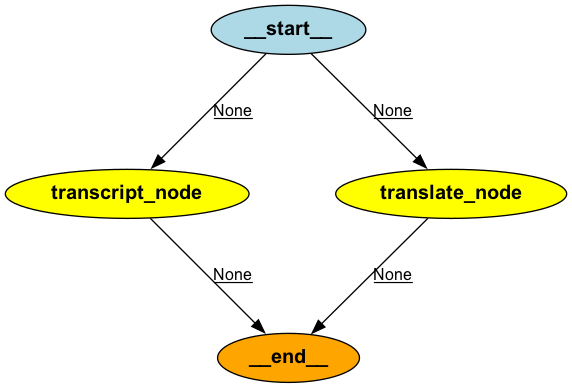

In [24]:
from IPython.display import Image, display

# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")

display(Image(workflow.get_graph().draw_png()))

## 8. Executing the Workflow and Printing State Changes

In this cell, we define parameters for the workflow execution:
- `iterations`: Number of iterations to run.
- `config`: Configuration for the workflow.
- `verbose`: Flag to control the verbosity of the output.
- `dict_inputs`: Initial inputs for the workflow.
- `limit`: Recursion limit for the workflow.

We then execute the workflow asynchronously and print the state changes in different colors based on the event name.

In [25]:
# Define workflow parameters
iterations = 10
config = {"configurable": {"thread_id": "1"}}
verbose = True
dict_inputs = {"start_chain": "start"}
limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
async for event in workflow.astream_events(dict_inputs, config=config, version="v2"):

    if verbose:
        if event["name"] == "transcript_node":
            print(colored(event, "yellow"))
        elif event["name"] == "translate_node":
            print(colored(event, "green"))
        else:
            print(colored(event, "magenta"))
    else:
        print("\n")

{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'a4df47fa-7674-4853-84a7-84fbc3ef602d', 'metadata': {'thread_id': '1'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '4043baf1-9b16-4e96-8f76-b40358e58eda', 'metadata': {'thread_id': '1', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0, 'thread_ts': '1ef53257-9e8f-67d2-bffe-23fdbb488db9'}, 'parent_ids': ['a4df47fa-7674-4853-84a7-84fbc3ef602d']}
{'event': 'on_chain_end', 'data': {'output': {'start_chain': 'start'}, 'input': {'start_chain': 'start'}}, 'run_id': '4043baf1-9b16-4e96-8f76-b40358e58eda', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'thread_id': '1', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'lang

/Users/gsampaio/redhat/ai/llm-agents/.conda/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


{'event': 'on_chain_start', 'data': {}, 'name': 'transcript_node', 'tags': ['graph:step:1'], 'run_id': '11441b80-187d-4ad4-bd70-2eaaf1b4b0d3', 'metadata': {'thread_id': '1', 'langgraph_step': 1, 'langgraph_node': 'transcript_node', 'langgraph_triggers': ['start:transcript_node'], 'langgraph_task_idx': 0, 'thread_ts': '1ef53257-9e8f-67d2-bffe-23fdbb488db9'}, 'parent_ids': ['a4df47fa-7674-4853-84a7-84fbc3ef602d']}
{'event': 'on_chain_start', 'data': {}, 'name': 'translate_node', 'tags': ['graph:step:1'], 'run_id': '1a9c1d66-8664-4daa-8b4e-bc12c87fced9', 'metadata': {'thread_id': '1', 'langgraph_step': 1, 'langgraph_node': 'translate_node', 'langgraph_triggers': ['start:translate_node'], 'langgraph_task_idx': 1, 'thread_ts': '1ef53257-9e8f-67d2-bffe-23fdbb488db9'}, 'parent_ids': ['a4df47fa-7674-4853-84a7-84fbc3ef602d']}
{'event': 'on_chain_start', 'data': {}, 'name': 'transcript_node', 'tags': ['seq:step:1'], 'run_id': '29ca9ae9-f4c2-40fc-bd8d-8a7f8f734053', 'metadata': {'thread_id': '1',